In [1]:
import pandas as pd
from load import load_all_sis_data

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping)

All data shape: (8, 63504, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5}


In [2]:
import numpy as np
energy_level_to_compute = 1

# Precompute the Q1 values for each element
q1_values = {}
for element_name, element_index in element_mapping.items():
    valid_data_mask = (all_flux_data[energy_level_to_compute - 1, :, element_index] != -999.9) & (all_flux_data[energy_level_to_compute - 1, :, element_index] != 0)
    element_flux_for_stats = all_flux_data[energy_level_to_compute - 1, :, element_index][valid_data_mask]
    if len(element_flux_for_stats) > 0:
        q1_values[element_name] = np.percentile(element_flux_for_stats, 25)

# 3x multiplier for He and O to account for abundance
q1_values["He"] *= 3
q1_values["O"] *= 2.25
print(q1_values)

{'C': 8.8071e-06, 'Fe': 3.7664e-06, 'He': 7.9458e-05, 'N': 7.4286e-06, 'O': 1.5245325e-05, 'Si': 5.0896500000000005e-06}


Code below is purely for visualization; all it does is treat the Q1 flux cutoff as the new X-axis in order to show the flux data without the background/quiet time noise.

NOTE: It seems like the noise/quiet time flux level for oxygen starts decreasing at the 2021/2022 mark. Not sure how to handle this...


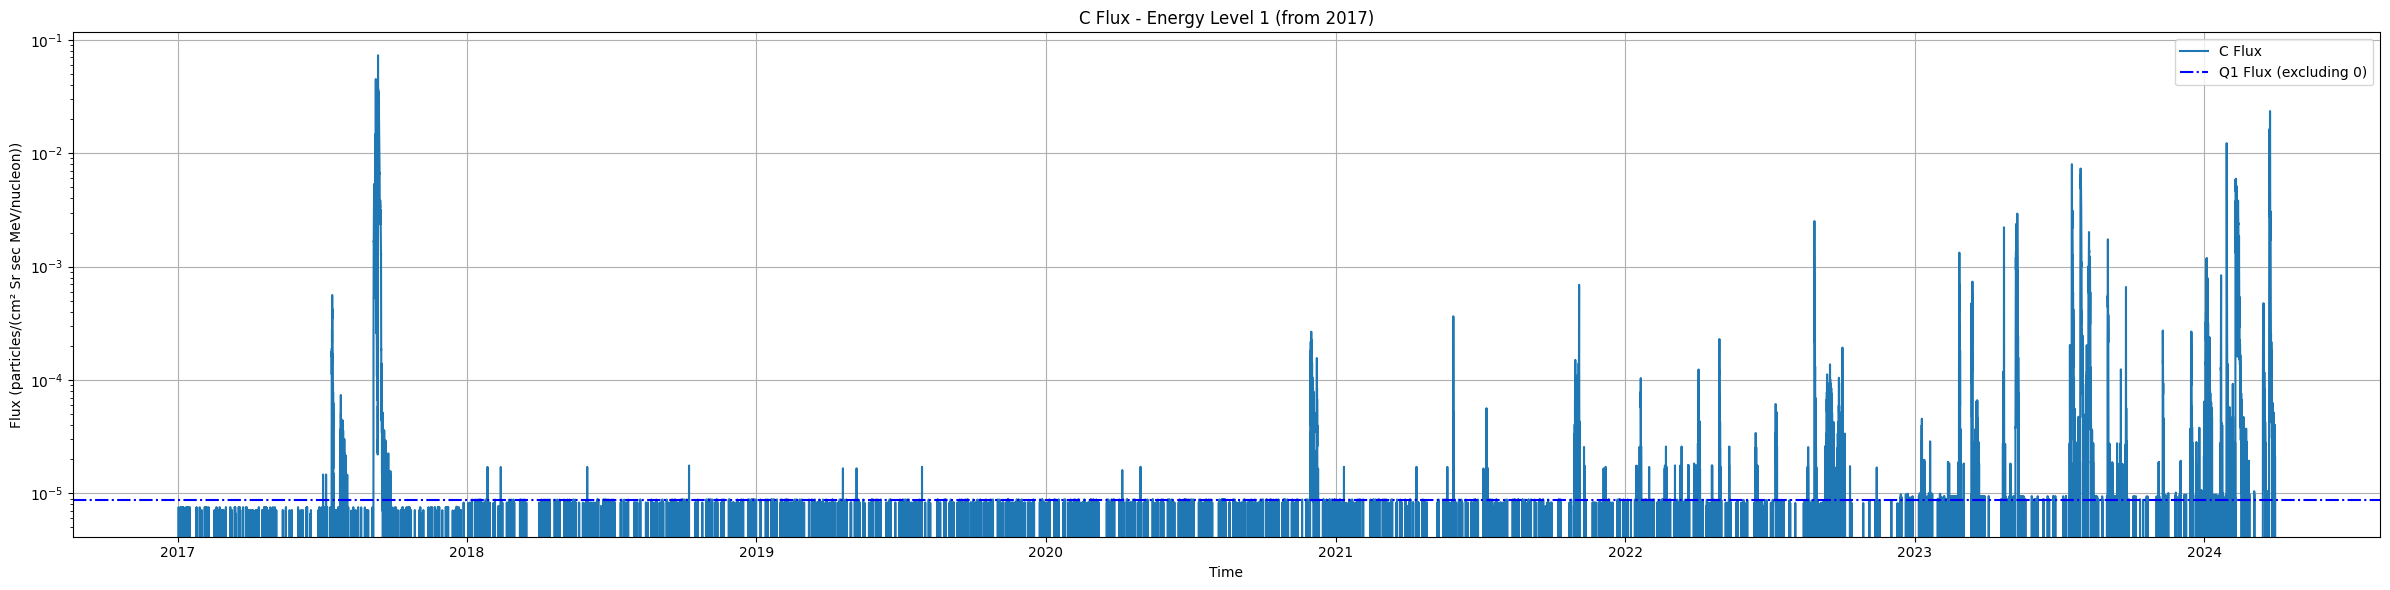

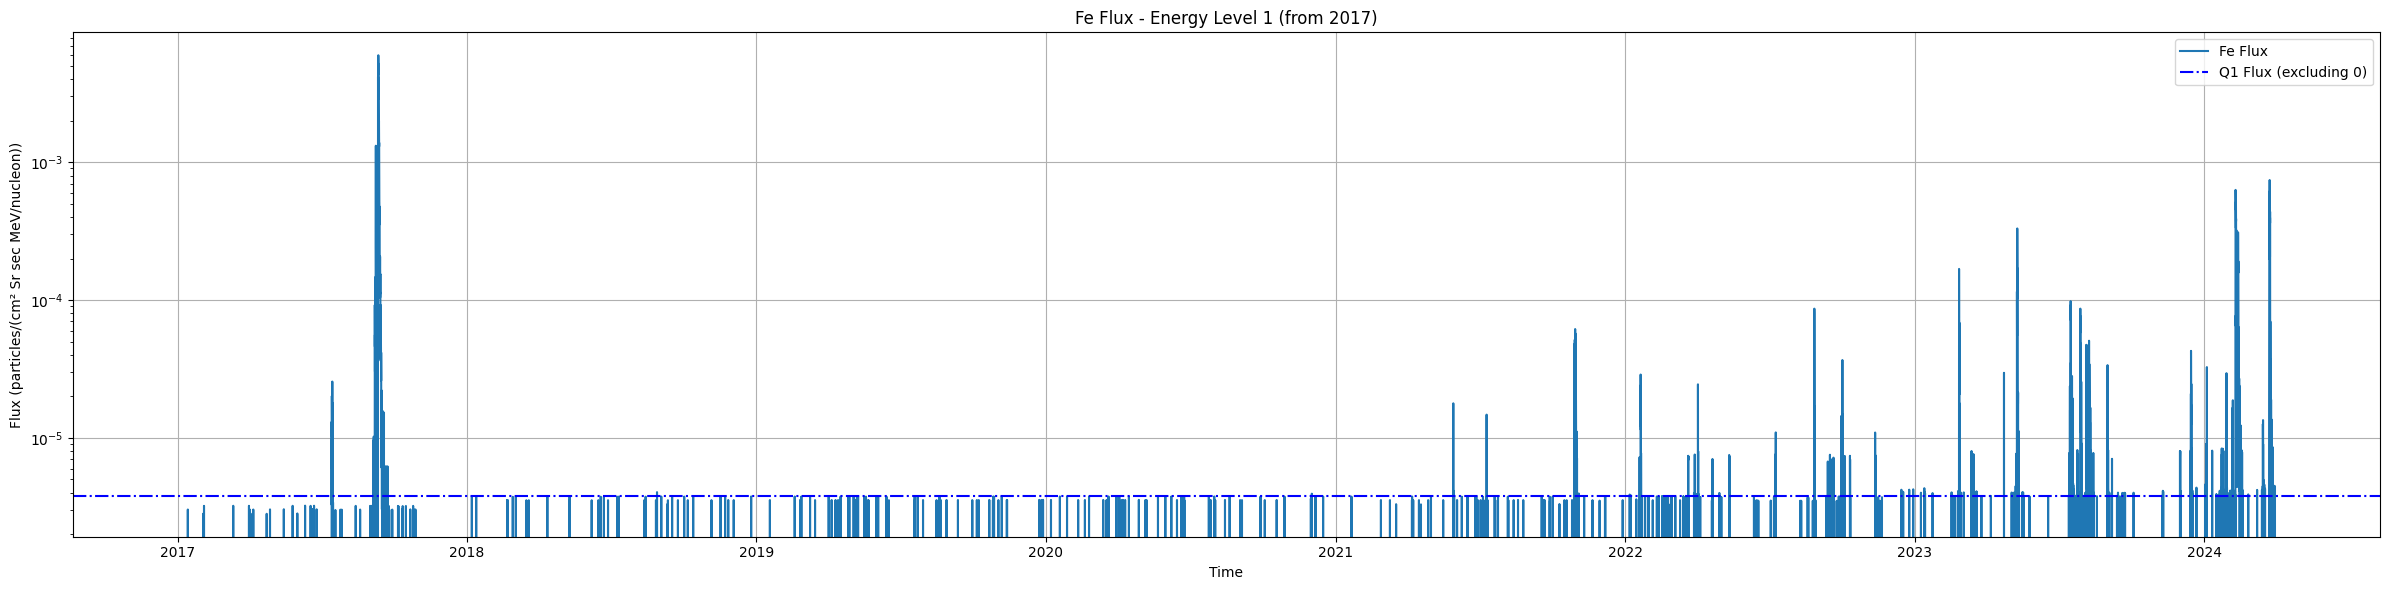

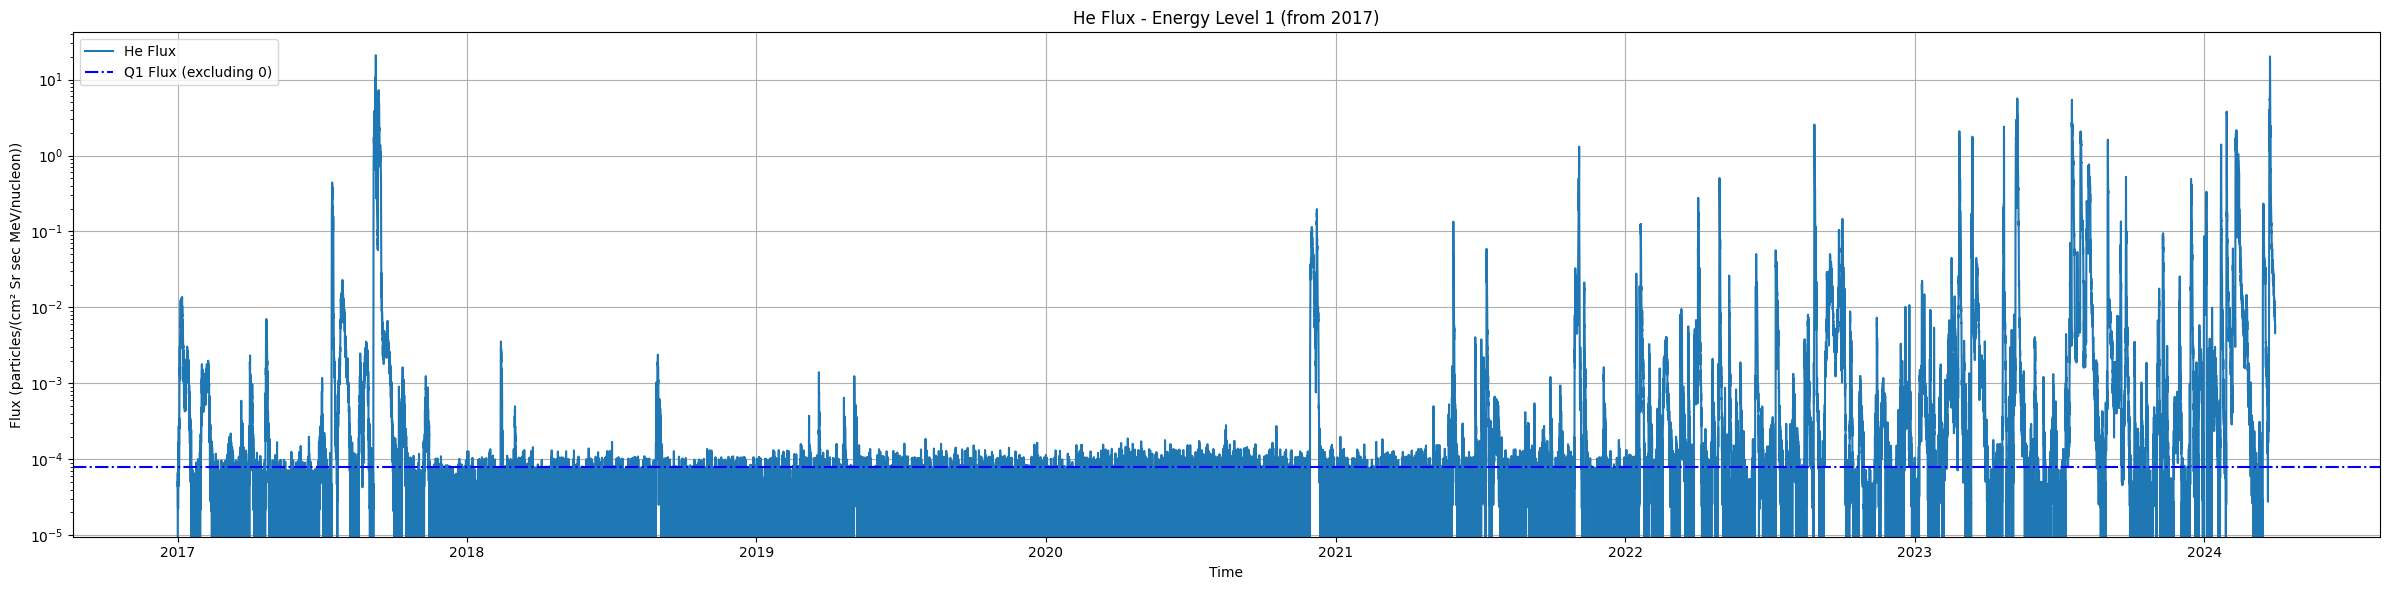

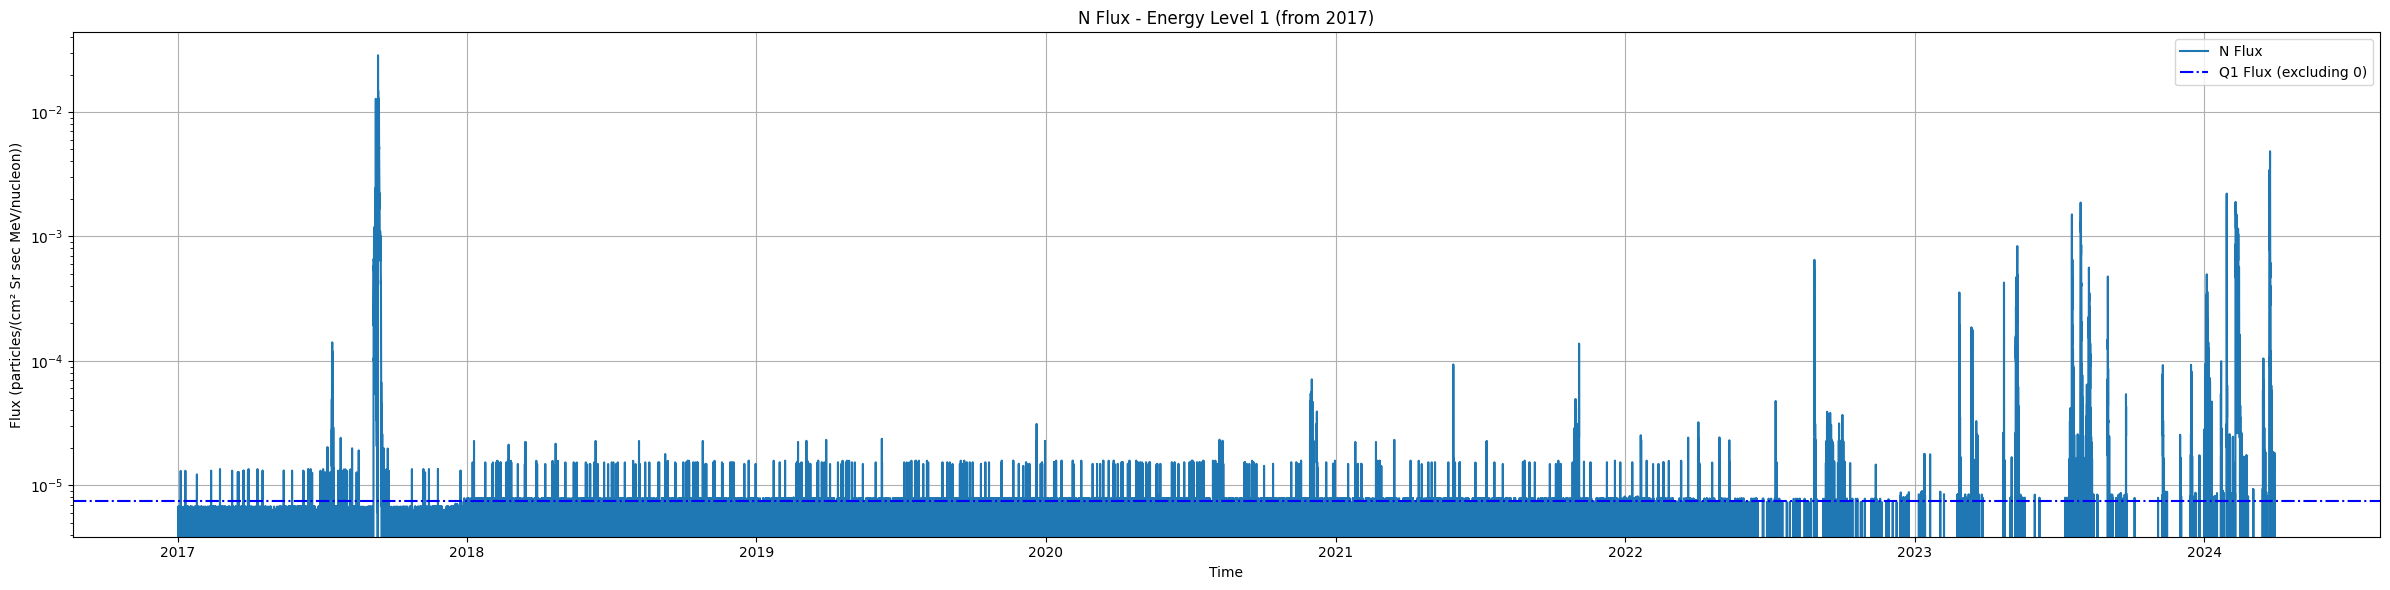

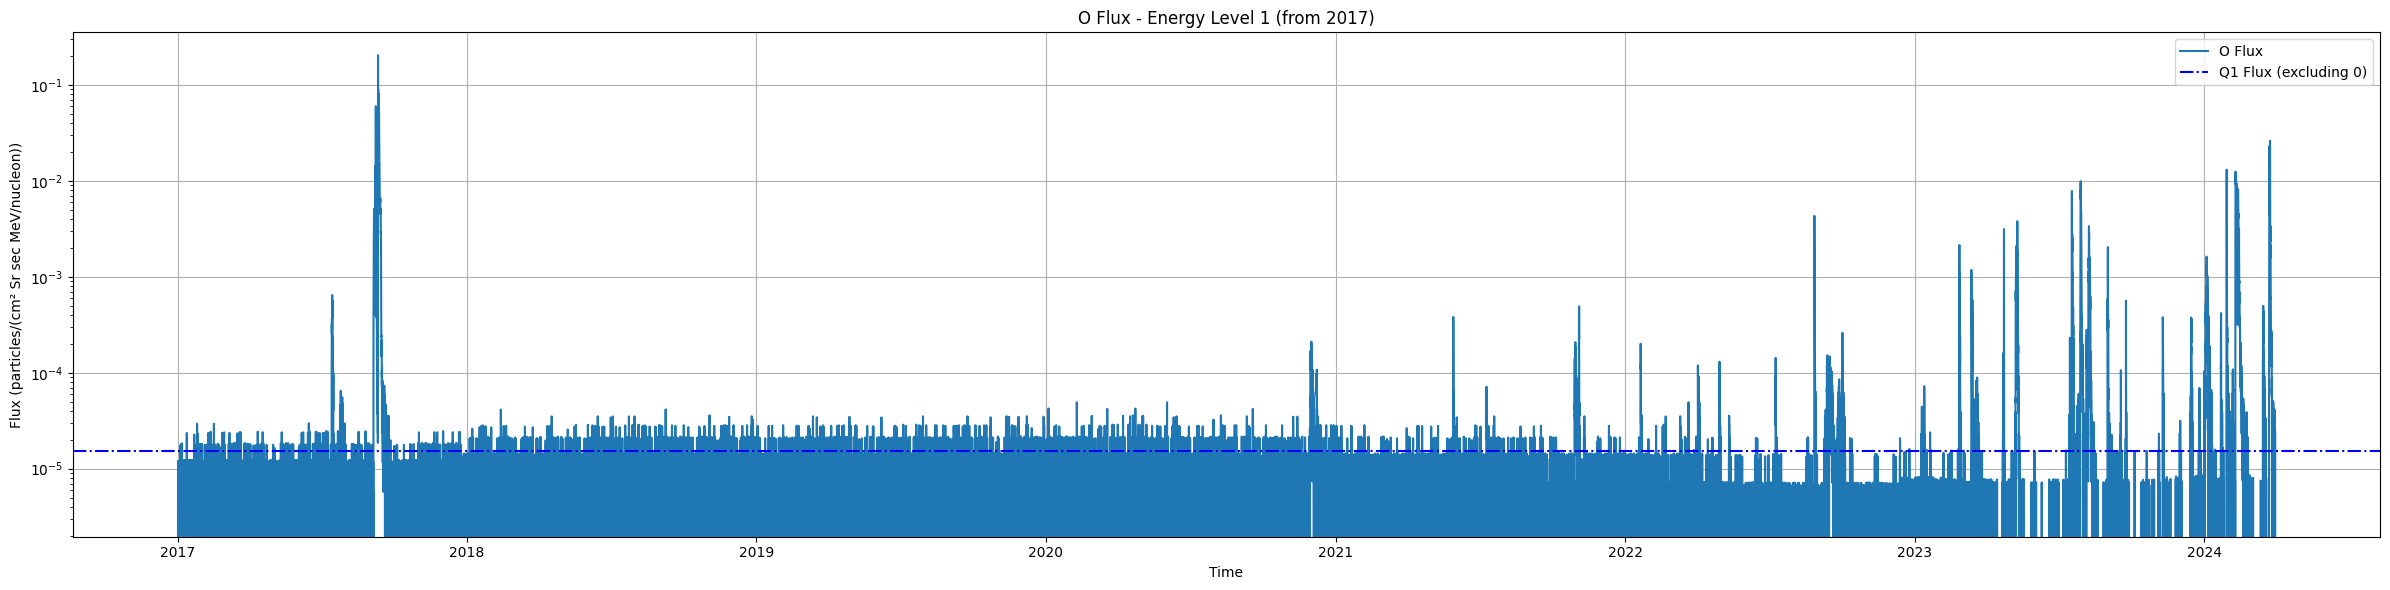

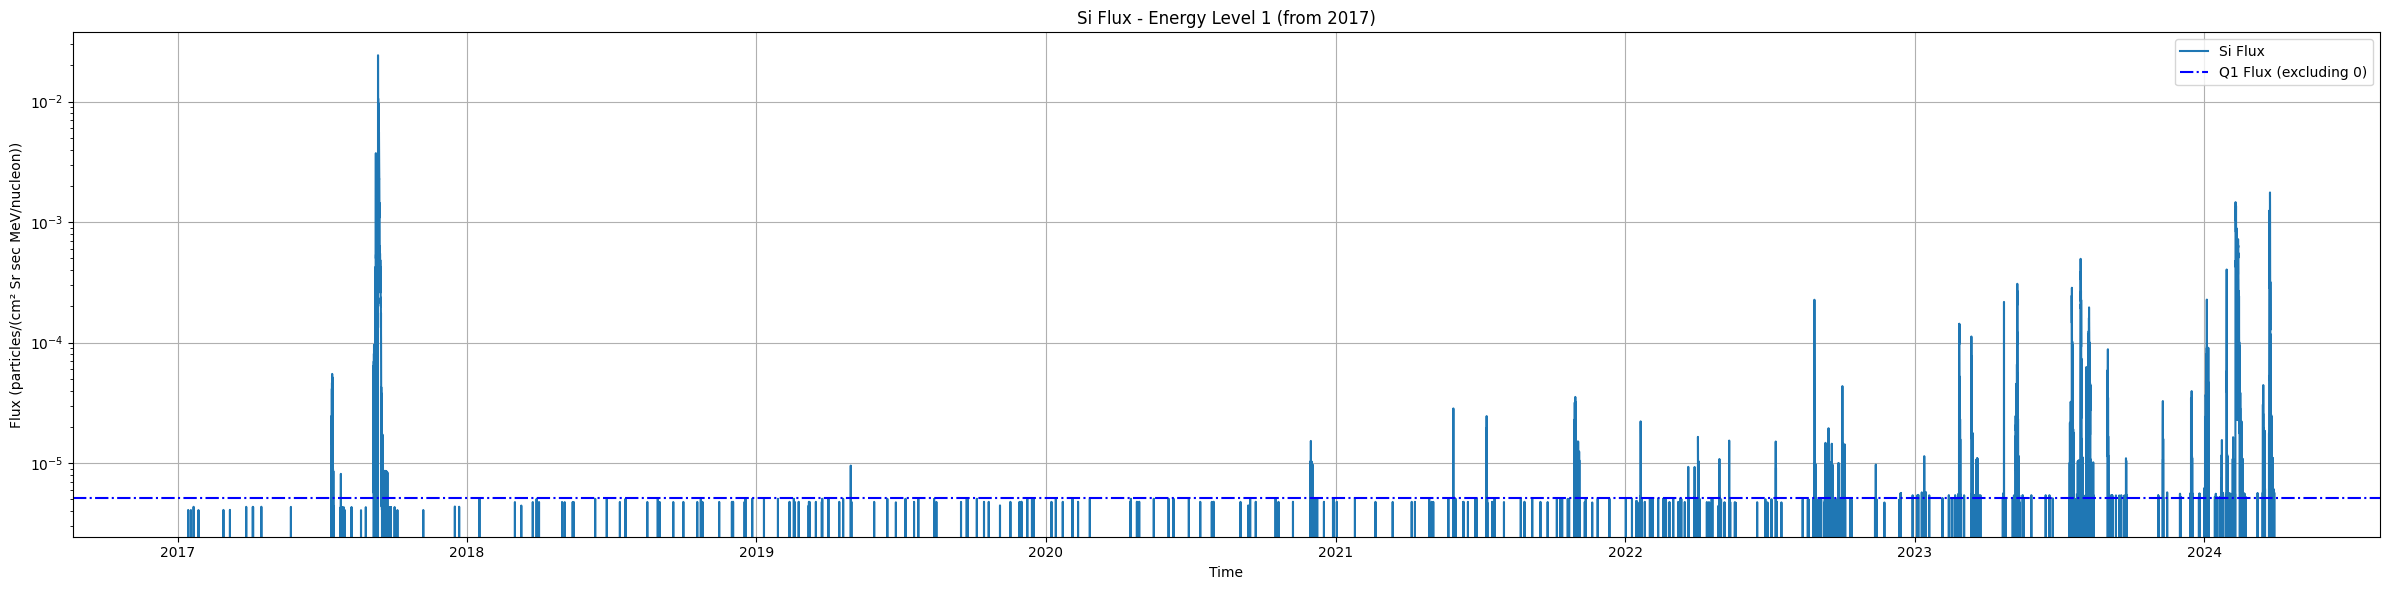

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

def plot_element_fluxes(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time, q1_values):
    """
    Plots separate graphs for flux data of each element at a specified energy level, 
    starting from a given year and omitting bad data (-999.9). 
    Keeps the original data points in the graph while plotting the precomputed Q1 threshold.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to plot.
        start_time (datetime): Start time for the analysis window.
        end_time (datetime): End time for the analysis window.
        q1_values (dict): Dictionary of precomputed Q1 values for each element.
    """
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6)) 

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points (-999.9) for plotting
        plot_data_mask = element_flux != -999.9
        element_flux_to_plot = element_flux[plot_data_mask]
        element_time_to_plot = datetime_values[time_mask][plot_data_mask]

        if element_name not in q1_values:
            continue

        q1_flux = q1_values[element_name]

        plt.plot(element_time_to_plot, element_flux_to_plot, label=f'{element_name} Flux')
        plt.axhline(q1_flux, color='b', linestyle='-.', label='Q1 Flux (excluding 0)')
        plt.yscale('log')
        # plt.ylim(q1_flux)

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))') 
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

energy_level_to_plot = 1
start_time = pd.to_datetime('2017-01-01')
end_time = pd.to_datetime('2024-04-01')

plot_element_fluxes(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time, q1_values)


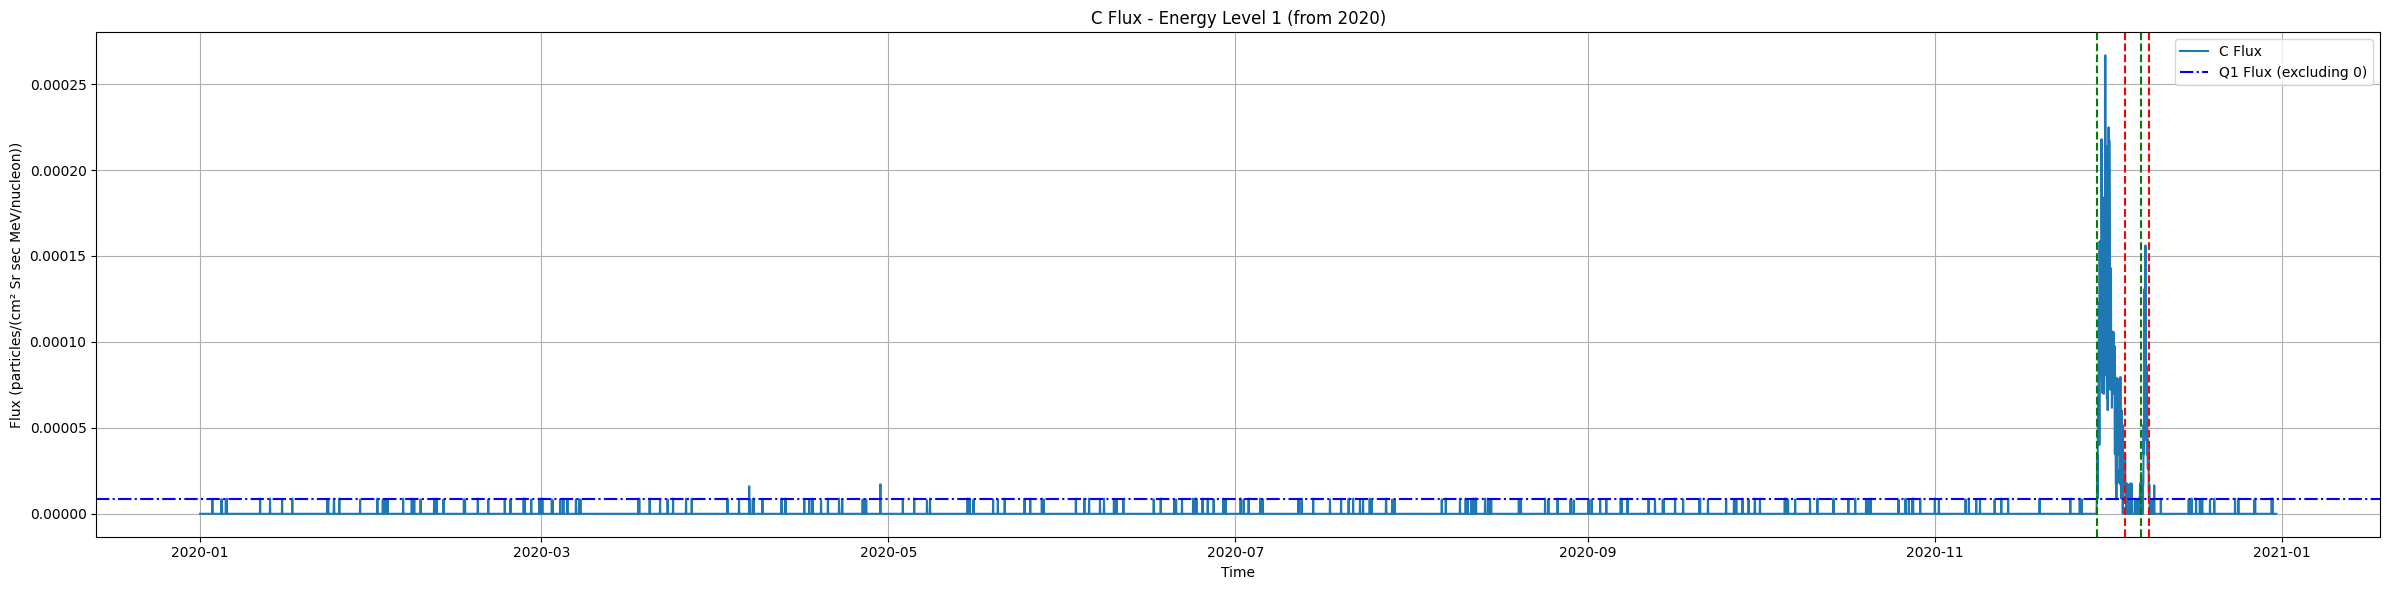

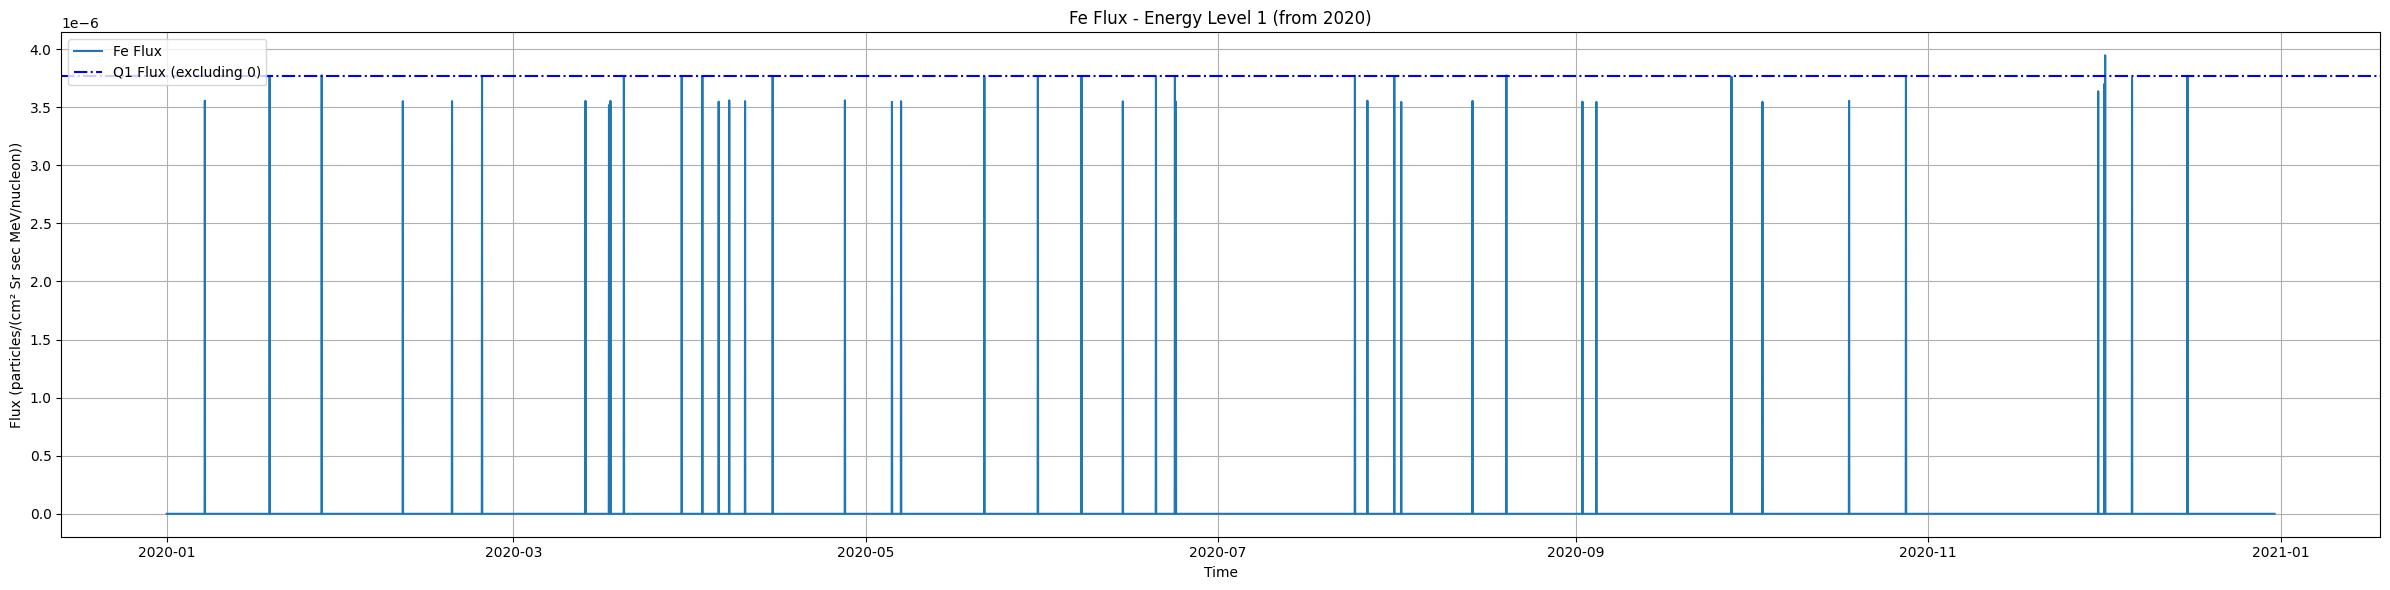

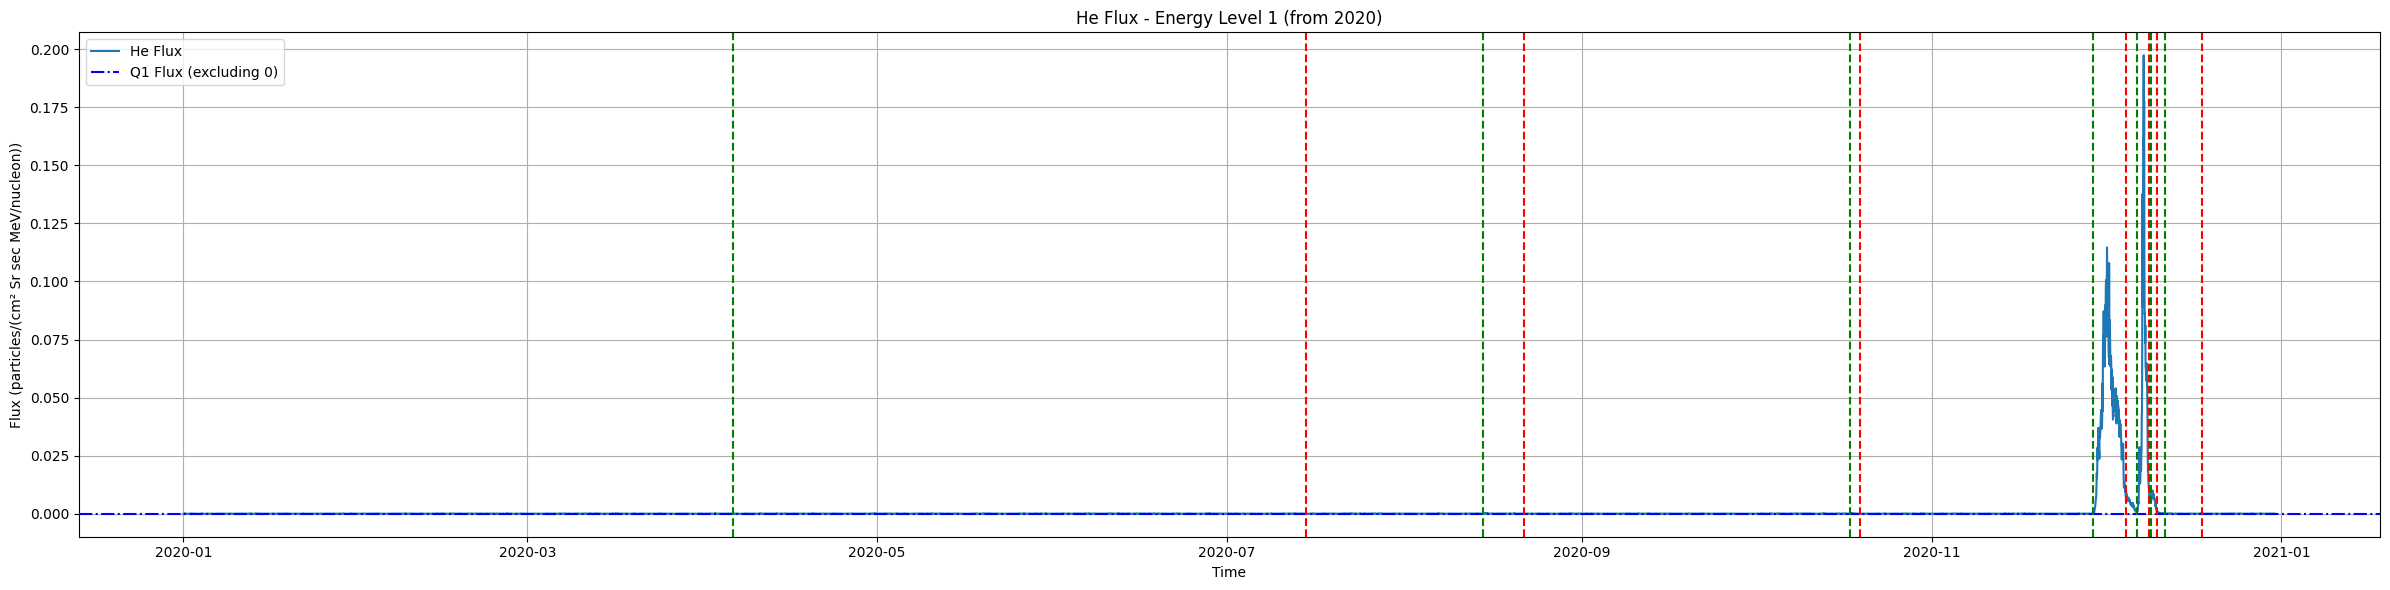

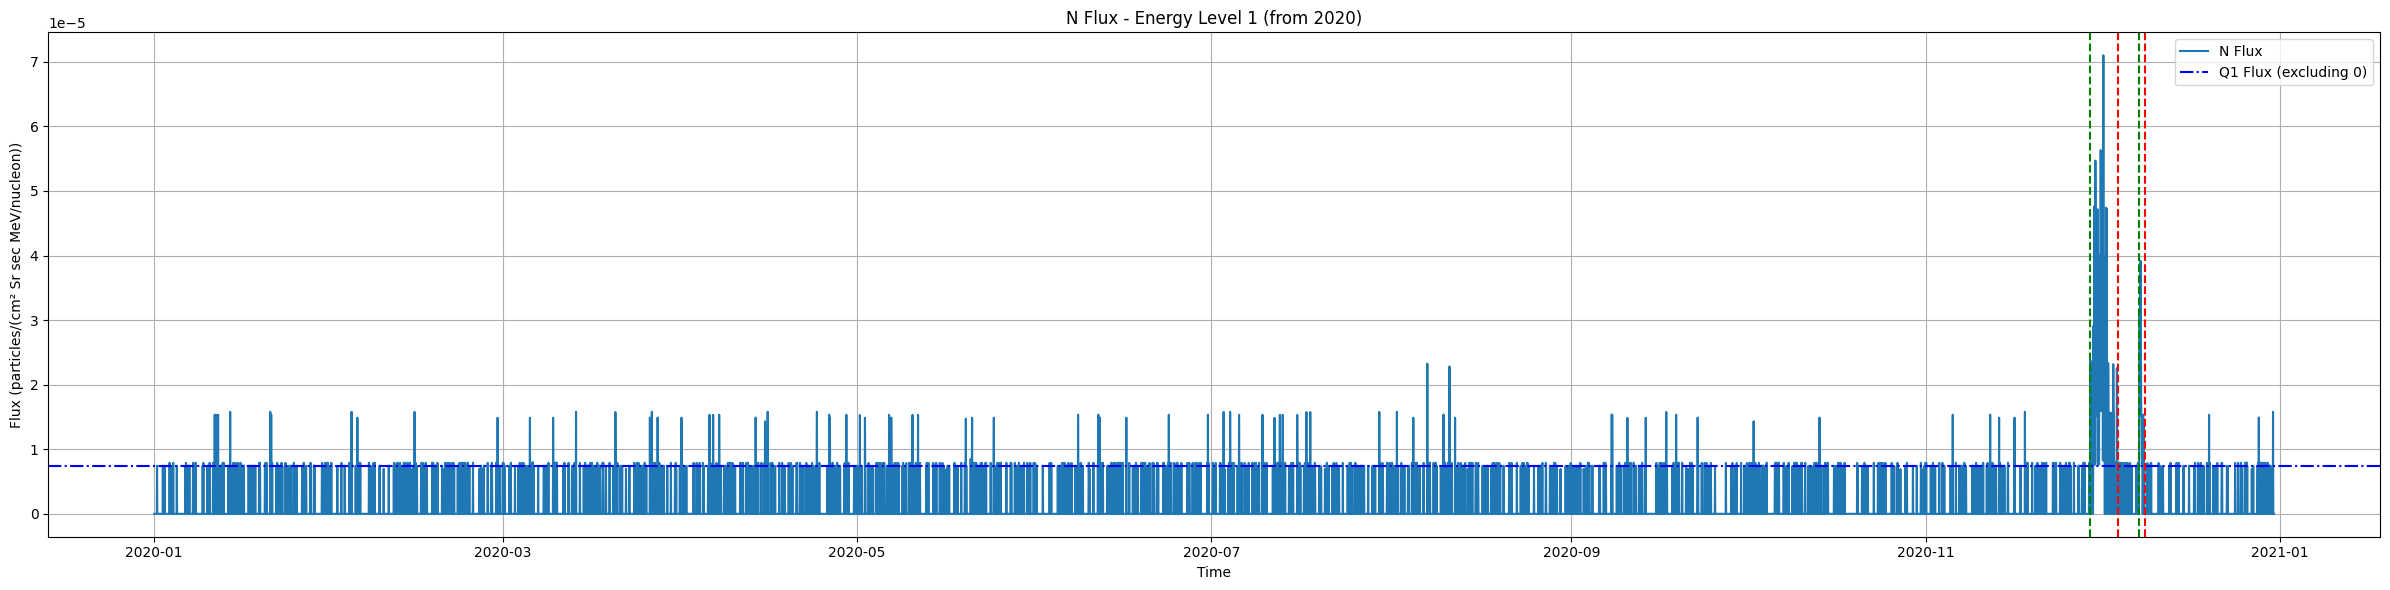

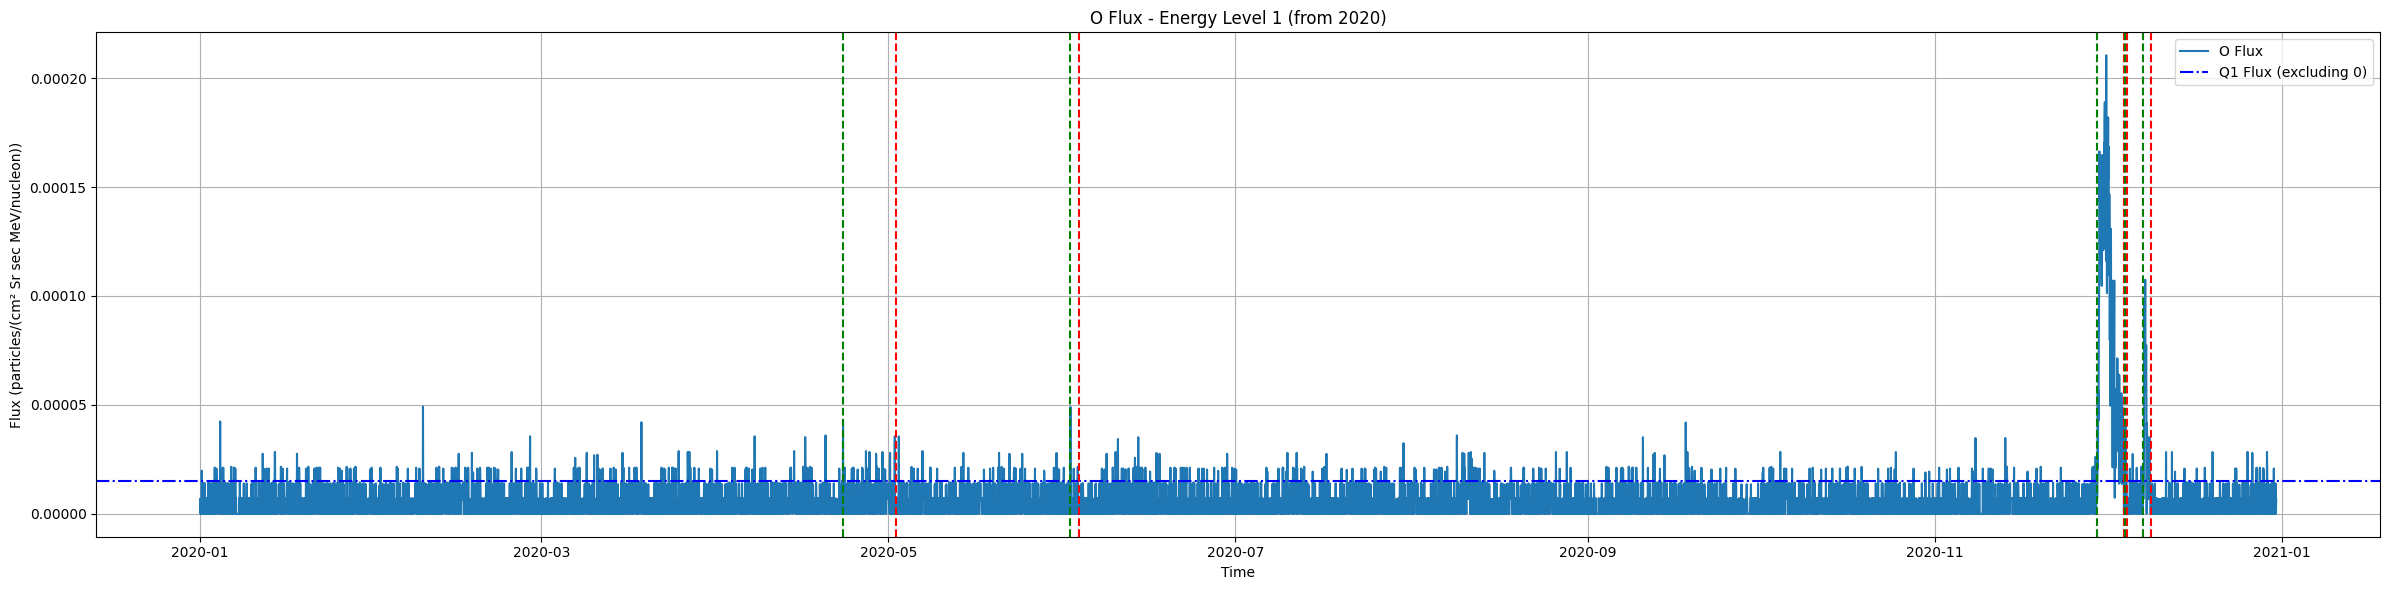

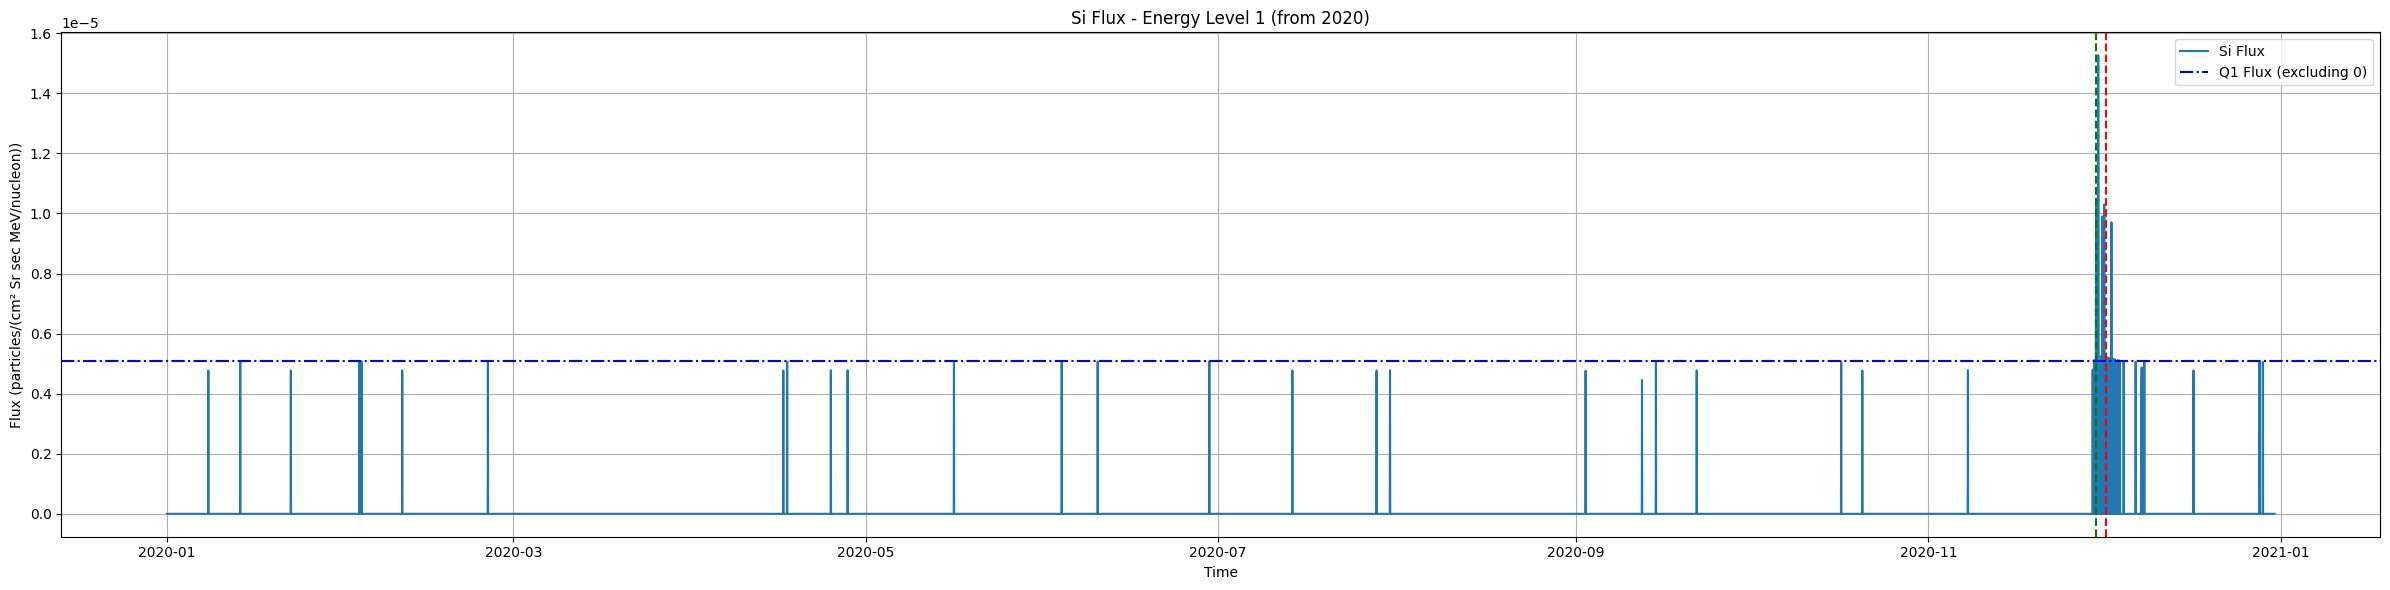

    Element                 Start Time                   End Time
0         C 2017-07-14 03:00:00.155519 2017-07-16 05:59:59.909276
1         C 2017-07-25 06:59:59.925118 2017-07-30 23:00:00.109442
2         C 2017-09-04 20:00:00.070562 2017-09-08 10:59:59.854562
3         C 2017-09-10 07:00:00.136803 2017-09-12 22:00:00.110878
4         C 2017-09-13 02:59:59.913597 2017-09-14 16:59:59.928001
..      ...                        ...                        ...
481      Si 2024-02-11 21:14:45.297600 2024-02-14 21:02:57.059517
482      Si 2024-02-16 14:56:03.920636 2024-02-17 16:51:48.273119
483      Si 2024-03-15 04:07:22.543679 2024-03-16 18:01:08.856476
484      Si 2024-03-22 22:36:43.302243 2024-03-24 18:29:30.595201
485      Si 2024-03-25 21:25:05.005918 2024-03-26 19:21:28.494723

[486 rows x 3 columns]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def calculate_slope(data, window_size):
    slopes = np.zeros_like(data)
    for i in range(len(data)):
        if i < window_size:
            slopes[i] = (data[i + window_size] - data[i]) / window_size
        elif i >= len(data) - window_size:
            slopes[i] = (data[i] - data[i - window_size]) / window_size
        else:
            slopes[i] = (data[i + window_size] - data[i - window_size]) / (2 * window_size)
    return slopes

def identify_events(flux_data, time_data, q1_flux, min_event_duration_hours, smoothing_factor):
    smoothed_flux_data = gaussian_filter1d(flux_data, smoothing_factor)
    window_size = min_event_duration_hours // 2
    slopes = calculate_slope(smoothed_flux_data, window_size)

    events = []
    event_start = None
    peak_flux = None
    min_event_duration_timedelta = pd.Timedelta(hours=min_event_duration_hours)

    for i in range(window_size, len(smoothed_flux_data) - window_size):
        if smoothed_flux_data[i] > q1_flux and slopes[i] > 0:
            if event_start is None:
                event_start = time_data[i]
                peak_flux = smoothed_flux_data[i]
            else:
                peak_flux = max(peak_flux, smoothed_flux_data[i])
        elif event_start is not None and (slopes[i] < 0 or smoothed_flux_data[i] <= q1_flux) and smoothed_flux_data[i] < peak_flux / 10:
            event_end = time_data[i]
            if event_end - event_start >= min_event_duration_timedelta:
                flux_start = smoothed_flux_data[np.where(time_data == event_start)[0][0]]
                flux_end = smoothed_flux_data[np.where(time_data == event_end)[0][0]]

                best_end = event_end
                best_diff = abs(flux_end - flux_start)
                lengthening = True

                while lengthening:
                    new_end = event_end + pd.Timedelta(hours=2)
                    if new_end >= time_data[-1]:
                        break

                    new_end_indices = np.where(time_data == new_end)[0]
                    if len(new_end_indices) == 0:
                        break

                    new_end_flux = smoothed_flux_data[new_end_indices[0]]
                    new_diff = abs(new_end_flux - flux_start)

                    if new_diff <= best_diff:
                        best_end = new_end
                        best_diff = new_diff
                        event_end = new_end
                    else:
                        lengthening = False

                events.append((event_start, best_end))
            event_start = None
            peak_flux = None

    return events

def plot_flux(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time, q1_values, smoothing_factor, min_event_duration_hours):
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6))

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        q1_flux = q1_values.get(element_name, 0)

        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.axhline(q1_flux, color='b', linestyle='-.', label='Q1 Flux (excluding 0)')

        events = identify_events(element_flux, element_time, q1_flux, min_event_duration_hours, smoothing_factor)
        for start, end in events:
            plt.axvline(start, color='g', linestyle='--', label='_nolegend_')
            plt.axvline(end, color='r', linestyle='--', label='_nolegend_')

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))')
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def create_event_dataframe(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time, q1_values, smoothing_factor, min_event_duration_hours):
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)
    all_events = []

    for element_name, element_index in element_mapping.items():
        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        q1_flux = q1_values.get(element_name, 0)
        events = identify_events(element_flux, element_time, q1_flux, min_event_duration_hours, smoothing_factor)
        for start, end in events:
            all_events.append((element_name, start, end))

    events_df = pd.DataFrame(all_events, columns=['Element', 'Start Time', 'End Time'])
    return events_df


energy_level_to_plot = 1
smoothing_factor = 2
min_event_duration_hours = 9

plot_start_time = pd.to_datetime('2020-01-01')
plot_end_time = pd.to_datetime('2020-12-31')
plot_flux(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, plot_start_time, plot_end_time, q1_values, smoothing_factor, min_event_duration_hours)

df_start_time = pd.to_datetime('2017-01-01')
df_end_time = pd.to_datetime('2024-06-01')
events_df = create_event_dataframe(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, df_start_time, df_end_time, q1_values, smoothing_factor, min_event_duration_hours)

print(events_df)
events_df.to_csv('out_csv/general_sep_events.csv', index=False)


In [5]:
import pandas as pd

def analyze_events(all_events, reference_element):
    """
    Analyze and combine events across elements based on a reference element's events.

    Args:
        all_events (pd.DataFrame): DataFrame containing all events with columns ['Element', 'Start Time', 'End Time'].
        reference_element (str): The element name to use as the reference for event combination.

    Returns:
        pd.DataFrame: DataFrame containing start, end times, and elements involved in each combined event.
    """
    ref_events = all_events[all_events['Element'] == reference_element]
    combined_events = []

    for _, ref_event in ref_events.iterrows():
        ref_start, ref_end = ref_event['Start Time'], ref_event['End Time']
        ref_duration = (ref_end - ref_start).total_seconds()
        involved_elements = {reference_element}
        
        for _, event in all_events.iterrows():
            if event['Element'] != reference_element:
                event_start, event_end = event['Start Time'], event['End Time']
                event_duration = (event_end - event_start).total_seconds()
                
                # Calculate overlap
                overlap_start = max(ref_start, event_start)
                overlap_end = min(ref_end, event_end)
                overlap_duration = (overlap_end - overlap_start).total_seconds()
                
                # Check if 80% of the event overlaps with the reference event
                if overlap_duration >= 0.8 * min(ref_duration, event_duration):
                    involved_elements.add(event['Element'])

        combined_events.append({
            'Start Time': ref_start,
            'End Time': ref_end,
            'Elements': ', '.join(involved_elements)
        })

    return pd.DataFrame(combined_events)


reference_element = 'He' 
combined_events_df = analyze_events(events_df, reference_element)
print(combined_events_df)
combined_events_df.to_csv('out_csv/combined_general_sep_events.csv', index=False)



                    Start Time                   End Time             Elements
0   2017-01-01 15:59:59.873282 2017-01-08 22:00:00.072002                   He
1   2017-01-09 19:00:00.063361 2017-01-16 20:00:00.143998                   He
2   2017-01-17 10:00:00.033121 2017-01-18 09:59:59.843038                   He
3   2017-01-29 19:00:00.046077 2017-02-11 06:59:59.877598                   He
4   2017-02-11 21:00:00.082077 2017-02-16 23:59:59.896320                   He
..                         ...                        ...                  ...
198 2024-03-01 15:00:49.183201 2024-03-04 21:47:51.983520                   He
199 2024-03-10 16:25:04.900797 2024-03-13 01:15:44.212318                   He
200 2024-03-14 23:08:11.937123 2024-03-18 13:53:56.149442  He, Si, C, Fe, O, N
201 2024-03-19 06:51:08.716319 2024-03-21 05:43:26.499358                   He
202 2024-03-21 14:41:57.969599 2024-03-25 01:28:21.633596  He, Si, C, Fe, O, N

[203 rows x 3 columns]


In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

def plot_events_grid(events_df, data_3d, datetime_values, element_mapping, energy_level, extend_days=1):
    """
    Args:
        events_df (pd.DataFrame): DataFrame containing decay event details with columns 'Element', 'Start Time', and 'End Time'.
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to analyze.
        extend_days (int): Number of days to extend the time range before and after the event.
    """

    num_events = len(events_df)
    if num_events == 0:
        print("No events found to plot.")
        return

    # Define a fixed color map for each element
    element_colors = {
        'C': 'blue',
        'O': 'green',
        'He': 'red',
        'Si': 'purple',
        'Fe': 'orange',
        'N': 'brown'
    }

    num_cols = 5
    num_rows = int(np.ceil(num_events / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), sharey=False)
    fig.subplots_adjust(hspace=0.5, top=0.95)

    for i, row in events_df.iterrows():
        ax = axes[i // num_cols, i % num_cols]

        element_name = row['Element']
        if element_name not in element_mapping:
            continue
        element_index = element_mapping[element_name]
        element_color = element_colors.get(element_name, 'black')

        start_time = pd.to_datetime(row['Start Time'])
        end_time = pd.to_datetime(row['End Time'])

        extended_start_time = start_time - pd.Timedelta(days=extend_days)
        extended_end_time = end_time + pd.Timedelta(days=extend_days)

        time_mask = (datetime_values >= extended_start_time) & (datetime_values <= extended_end_time)
        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        # Plotting the element flux
        ax.plot(element_time, element_flux, label=f"{element_name}", color=element_color)

        # Compute and plot the Q1 threshold
        q1 = np.percentile(element_flux, 25)
        ax.axhline(y=q1, color=element_color, linestyle='--', linewidth=1)

        ax.set_xlabel("Day of Year")
        if i % num_cols == 0:
            ax.set_ylabel("Flux (particles/(cm² Sr sec MeV/nucleon))")
        ax.set_title(f"{element_name} Event {i+1} ({start_time.year})")
        ax.grid(True)

        # Set major ticks to daily and limit the number of ticks
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(element_time) // 10)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%j"))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        ax.axvline(start_time, color="black", linestyle="--", linewidth=1)
        ax.axvline(end_time, color="black", linestyle="--", linewidth=1)

    for j in range(i + 1, num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # Print out text that maps each element to its color
    for element, color in element_colors.items():
        print(f"{element}: {color}")

# Example usage with events_df
energy_level_to_plot = 1
extend_days = 0.25

#plot_events_grid(events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days)


In [15]:
import pandas as pd
import numpy as np
from graph import plot_all_decay_events

def convert_dataframe(df):
    # Convert the 'Start Time' and 'End Time' columns to datetime
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    df['End Time'] = pd.to_datetime(df['End Time'])

    # Extract the year, fractional day and hour from the 'Start Time' and 'End Time'
    df['Start Year'] = df['Start Time'].dt.year
    df['End Year'] = df['End Time'].dt.year
    
    df['Start Fractional Day'] = df['Start Time'].dt.dayofyear + (
        df['Start Time'].dt.hour / 24.0 + 
        df['Start Time'].dt.minute / 1440.0 + 
        df['Start Time'].dt.second / 86400.0 +
        df['Start Time'].dt.microsecond / 86400000000.0
    )
    
    df['End Fractional Day'] = df['End Time'].dt.dayofyear + (
        df['End Time'].dt.hour / 24.0 + 
        df['End Time'].dt.minute / 1440.0 + 
        df['End Time'].dt.second / 86400.0 +
        df['End Time'].dt.microsecond / 86400000000.0
    )

    df['Start Hour'] = df['Start Time'].dt.hour + df['Start Time'].dt.minute / 60.0
    df['End Hour'] = df['End Time'].dt.hour + df['End Time'].dt.minute / 60.0

    # Create the 'Event Number' column
    df['Event Number'] = np.arange(1, len(df) + 1)

    # Select and reorder the required columns
    result_df = df[['Event Number', 'Start Year', 'End Year', 'Start Fractional Day', 'End Fractional Day', 'Start Hour', 'End Hour']]

    return result_df

# Example usage:
# Assuming `df` is the dataframe loaded with the initial data
result_df = convert_dataframe(combined_events_df)
print(result_df)
# plot_all_decay_events(combined_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, True)


     Event Number  Start Year  End Year  Start Fractional Day  \
0               1        2017      2017              1.666665   
1               2        2017      2017              9.791667   
2               3        2017      2017             17.416667   
3               4        2017      2017             29.791667   
4               5        2017      2017             42.875001   
..            ...         ...       ...                   ...   
198           199        2024      2024             61.625569   
199           200        2024      2024             70.684084   
200           201        2024      2024             74.964027   
201           202        2024      2024             79.285518   
202           203        2024      2024             81.612476   

     End Fractional Day  Start Hour   End Hour  
0              8.916668   15.983333  22.000000  
1             16.833335   19.000000  20.000000  
2             18.416665   10.000000   9.983333  
3             42.291665